In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict 

sns.set()

In [3]:
trip_data = pd.read_csv('bikes_data_only/data/trip_data.csv')
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [4]:
trip_data['start_date'] = trip_data['Start Date'].apply(lambda x: x.split()[0])
trip_data['start_time'] = trip_data['Start Date'].apply(lambda x: x.split()[1][:2])

trip_data['end_date'] = trip_data['End Date'].apply(lambda x: x.split()[0])
trip_data['end_time'] = trip_data['End Date'].apply(lambda x: x.split()[1][:2])

trip_data = trip_data.drop(['Start Date', 'End Date'], axis=1)

In [5]:
df_start = pd.DataFrame({'start_count': trip_data.groupby(['start_date', 'start_time', 'Start Station']).size()}).reset_index()
df_end = pd.DataFrame({'end_count': trip_data.groupby(['end_date', 'end_time', 'End Station']).size()}).reset_index()

print(df_start.head())
print(df_end.head())

   start_date start_time  Start Station  start_count
0  01/01/2015         00             42            4
1  01/01/2015         00             45            1
2  01/01/2015         00             61            2
3  01/01/2015         00             62            1
4  01/01/2015         00             75            2
     end_date end_time  End Station  end_count
0  01/01/2015       00           47          1
1  01/01/2015       00           54          3
2  01/01/2015       00           64          1
3  01/01/2015       00           77          1
4  01/01/2015       01           56          2


In [6]:
new_trip_data = pd.merge(df_start, df_end, how='outer', left_on=['start_date', 'start_time', 'Start Station'], right_on=['end_date', 'end_time', 'End Station'])
new_trip_data.head()

,start_date,start_time,Start Station,start_count,end_date,end_time,End Station,end_count
0,01/01/2015,00,42.0,4.0,NaN,NaN,NaN,NaN
1,01/01/2015,00,45.0,1.0,NaN,NaN,NaN,NaN
2,01/01/2015,00,61.0,2.0,NaN,NaN,NaN,NaN
3,01/01/2015,00,62.0,1.0,NaN,NaN,NaN,NaN
4,01/01/2015,00,75.0,2.0,NaN,NaN,NaN,NaN


In [7]:
## filling nan values
def f(x1, x2):
    if x1 != x1:
        return x2
    return x1

new_trip_data['date'] = new_trip_data.apply(lambda x: f(x['start_date'], x['end_date']), axis=1)
new_trip_data['time'] = new_trip_data.apply(lambda x: f(x['start_time'], x['end_time']), axis=1)
new_trip_data['station'] = new_trip_data.apply(lambda x: f(x['Start Station'], x['End Station']), axis=1)
# new_trip_data.loc[:, 'data'] = new_trip_data.loc[:, 'start_time']

In [8]:
new_trip_data = new_trip_data.drop(['start_date', 'start_time', 'Start Station', 'end_date','end_time', 'End Station'], axis=1)

In [9]:
new_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198156 entries, 0 to 198155
Data columns (total 5 columns):
start_count    142515 non-null float64
end_count      138665 non-null float64
date           198156 non-null object
time           198156 non-null object
station        198156 non-null float64
dtypes: float64(3), object(2)
memory usage: 9.1+ MB


In [10]:
# new_trip_data = new_trip_data.fillna(0) ## filling0 for NAN in start_count, end_count
imp_constant = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='0')
new_trip_data.loc[:,:] = imp_constant.fit_transform(new_trip_data)
new_trip_data['start_count'] = new_trip_data['start_count'].astype('float64')
new_trip_data['end_count'] = new_trip_data['end_count'].astype('float64')

In [11]:
new_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198156 entries, 0 to 198155
Data columns (total 5 columns):
start_count    198156 non-null float64
end_count      198156 non-null float64
date           198156 non-null object
time           198156 non-null object
station        198156 non-null float64
dtypes: float64(3), object(2)
memory usage: 9.1+ MB


In [12]:
new_trip_data['net_rate'] = new_trip_data['start_count'] - new_trip_data['end_count']

In [13]:
new_trip_data.head()

,start_count,end_count,date,time,station,net_rate
0,4.0,0.0,01/01/2015,00,42.0,4.0
1,1.0,0.0,01/01/2015,00,45.0,1.0
2,2.0,0.0,01/01/2015,00,61.0,2.0
3,1.0,0.0,01/01/2015,00,62.0,1.0
4,2.0,0.0,01/01/2015,00,75.0,2.0


In [14]:
new_trip_data['station'].value_counts()

60.0    5683
70.0    5640
39.0    5525
67.0    5415
77.0    5342
        ... 
85.0     211
24.0     171
21.0     157
25.0      38
23.0      24
Name: station, Length: 76, dtype: int64

In [15]:
station_data = pd.read_csv('bikes_data_only/data/station_data.csv')
station_data.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [16]:
zip_code_map = {'San Jose': 95113, 'San Francisco': 94107, 'Redwood City': 94063, 'Palo Alto': 94301, 'Mountain View': 94041}
station_data['zip_code'] = station_data['City'].apply(lambda x: zip_code_map[x])

In [17]:
station_data.index = station_data['Id']
new_trip_data = new_trip_data.merge(station_data['zip_code'], left_on='station', right_on='Id')
new_trip_data.head()

,start_count,end_count,date,time,station,net_rate,zip_code
0,4.0,0.0,01/01/2015,00,42.0,4.0,94107
1,1.0,1.0,01/01/2015,15,42.0,0.0,94107
2,1.0,0.0,01/02/2015,13,42.0,1.0,94107
3,1.0,1.0,01/02/2015,15,42.0,0.0,94107
4,1.0,1.0,01/02/2015,19,42.0,0.0,94107


In [18]:
station_map = {23: 85, 25: 86, 49:87, 69:88, 72:90, 89:90}
new_trip_data['station'] = new_trip_data['station'].apply(lambda x: station_map[x] if x in station_map else x)
print(new_trip_data['station'].value_counts())

60.0    5683
70.0    5640
88.0    5571
39.0    5525
67.0    5415
        ... 
26.0     346
83.0     314
85.0     235
24.0     171
21.0     157
Name: station, Length: 70, dtype: int64


In [19]:
new_trip_data["weekday"] = new_trip_data['date'].apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%d/%m/%Y").weekday()])
new_trip_data["month"] = new_trip_data['date'].apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%d/%m/%Y").month])
new_trip_data.head()

,start_count,end_count,date,time,station,net_rate,zip_code,weekday,month
0,4.0,0.0,01/01/2015,00,42.0,4.0,94107,Thursday,January
1,1.0,1.0,01/01/2015,15,42.0,0.0,94107,Thursday,January
2,1.0,0.0,01/02/2015,13,42.0,1.0,94107,Sunday,February
3,1.0,1.0,01/02/2015,15,42.0,0.0,94107,Sunday,February
4,1.0,1.0,01/02/2015,19,42.0,0.0,94107,Sunday,February


In [20]:
weather_data = pd.read_csv('bikes_data_only/data/weather_data.csv')
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [21]:
weather_data = weather_data.drop(['Max TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       'Min Humidity', 'Max Sea Level PressureIn',
       'Mean Sea Level PressureIn', 'Min Sea Level PressureIn',
       'Max VisibilityMiles', 'Mean VisibilityMiles', 'Min VisibilityMiles',
       'Max Wind SpeedMPH', 'Max Gust SpeedMPH', 'Events', 'WindDirDegrees'], axis=1)

In [22]:
weather_data = weather_data.set_index(['Date', 'Zip'])
weather_data.head()

,,Mean TemperatureF,Mean Humidity,Mean Wind SpeedMPH,PrecipitationIn,CloudCover
Date,Zip,,,,,
01/09/2014,94107,70.0,64.0,7.0,0.0,0.0
02/09/2014,94107,66.0,73.0,8.0,0.0,5.0
03/09/2014,94107,69.0,69.0,8.0,0.0,4.0
04/09/2014,94107,68.0,71.0,8.0,0.0,5.0
05/09/2014,94107,66.0,71.0,8.0,0.0,4.0


In [23]:
new_trip_data = new_trip_data.merge(weather_data, left_on=['date', 'zip_code'], right_on=['Date', 'Zip'])
new_trip_data.head()

,start_count,end_count,date,time,station,net_rate,zip_code,weekday,month,Mean TemperatureF,Mean Humidity,Mean Wind SpeedMPH,PrecipitationIn,CloudCover
0,4.0,0.0,01/01/2015,00,42.0,4.0,94107,Thursday,January,47.0,37.0,8.0,0.0,1.0
1,1.0,1.0,01/01/2015,15,42.0,0.0,94107,Thursday,January,47.0,37.0,8.0,0.0,1.0
2,0.0,1.0,01/01/2015,09,42.0,-1.0,94107,Thursday,January,47.0,37.0,8.0,0.0,1.0
3,1.0,0.0,01/01/2015,00,45.0,1.0,94107,Thursday,January,47.0,37.0,8.0,0.0,1.0
4,2.0,2.0,01/01/2015,15,45.0,0.0,94107,Thursday,January,47.0,37.0,8.0,0.0,1.0


In [24]:
new_trip_data['temp'] = new_trip_data['Mean TemperatureF']
new_trip_data['wind'] = new_trip_data['Mean Wind SpeedMPH']
new_trip_data['precip'] = new_trip_data['PrecipitationIn']
new_trip_data['cloud'] = new_trip_data['CloudCover']
new_trip_data['humidity'] = new_trip_data['Mean Humidity']
new_trip_data = new_trip_data.drop(['CloudCover', 'PrecipitationIn', 'Mean Wind SpeedMPH', 'Mean TemperatureF', 'Mean Humidity'], axis=1)
new_trip_data.head()

,start_count,end_count,date,time,station,net_rate,zip_code,weekday,month,temp,wind,precip,cloud,humidity
0,4.0,0.0,01/01/2015,00,42.0,4.0,94107,Thursday,January,47.0,8.0,0.0,1.0,37.0
1,1.0,1.0,01/01/2015,15,42.0,0.0,94107,Thursday,January,47.0,8.0,0.0,1.0,37.0
2,0.0,1.0,01/01/2015,09,42.0,-1.0,94107,Thursday,January,47.0,8.0,0.0,1.0,37.0
3,1.0,0.0,01/01/2015,00,45.0,1.0,94107,Thursday,January,47.0,8.0,0.0,1.0,37.0
4,2.0,2.0,01/01/2015,15,45.0,0.0,94107,Thursday,January,47.0,8.0,0.0,1.0,37.0


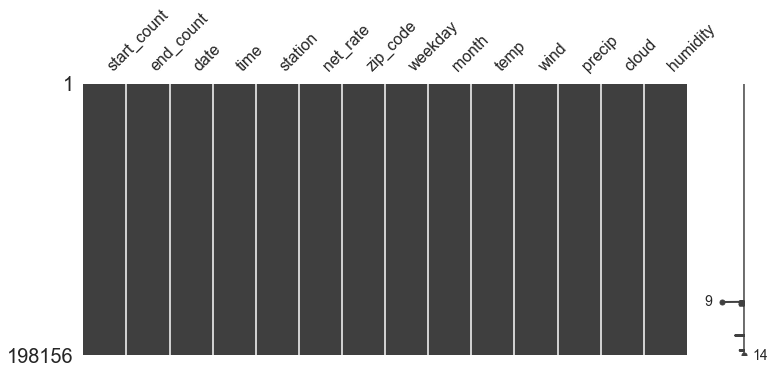

In [25]:
msno.matrix(new_trip_data,figsize=(12,5))

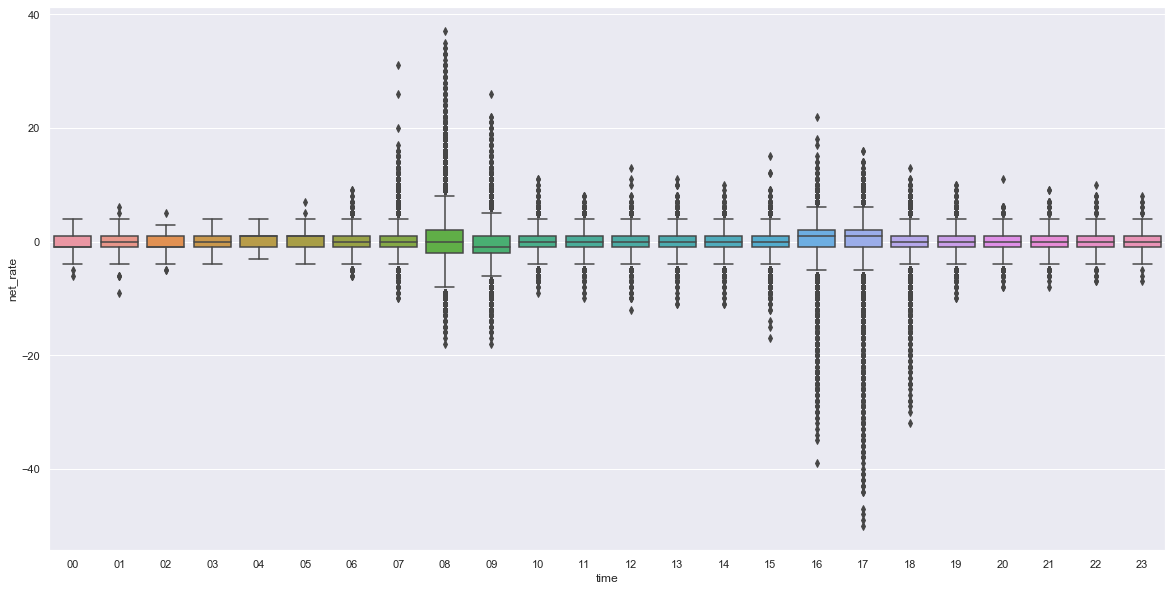

In [26]:
## many outliers, can try to remove outliers outside of 3 std distance

fig = plt.figure(figsize=(20, 10))
sns.boxplot(data=new_trip_data,y="net_rate",x="time",orient="v")

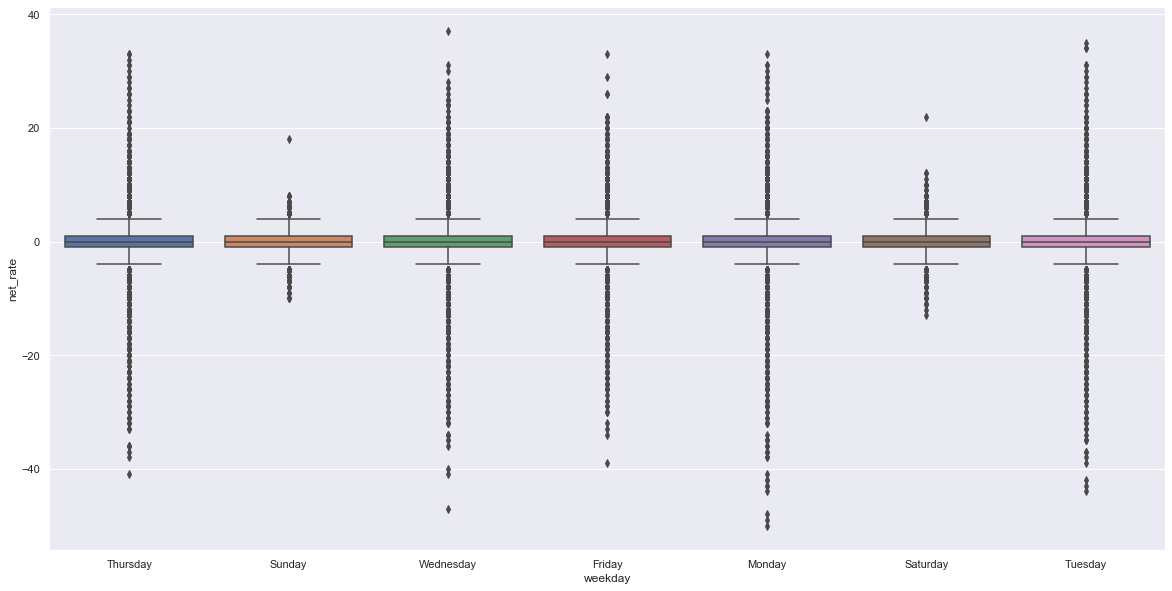

In [27]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=new_trip_data, y='net_rate', x='weekday', orient='v')

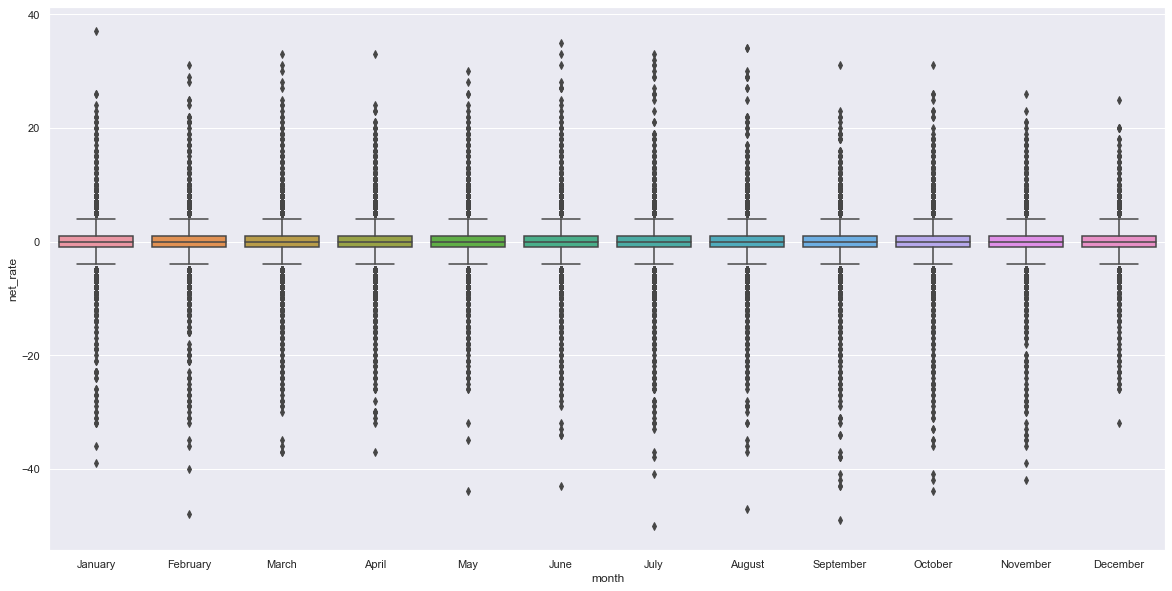

In [28]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=new_trip_data, y='net_rate', x='month', orient='v')

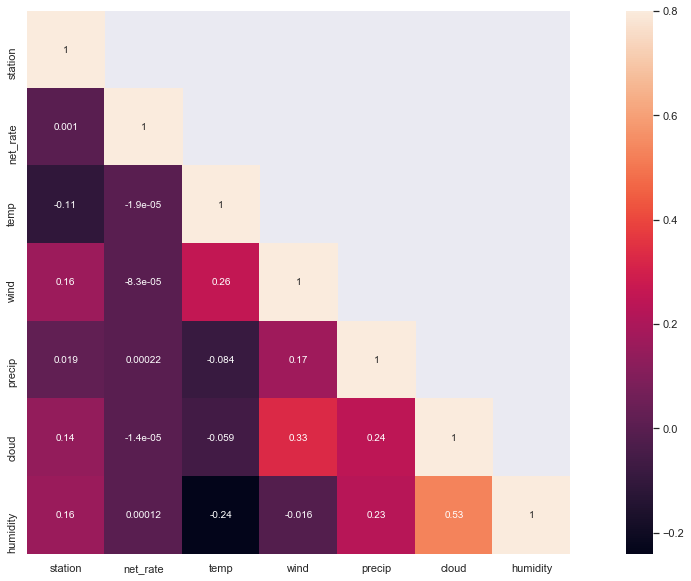

In [29]:
corrMatt = new_trip_data[['station', 'net_rate', 'temp', 'wind', 'precip', 'cloud', 'humidity']].corr()

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig,ax= plt.subplots()
fig.set_size_inches(20,10)

sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

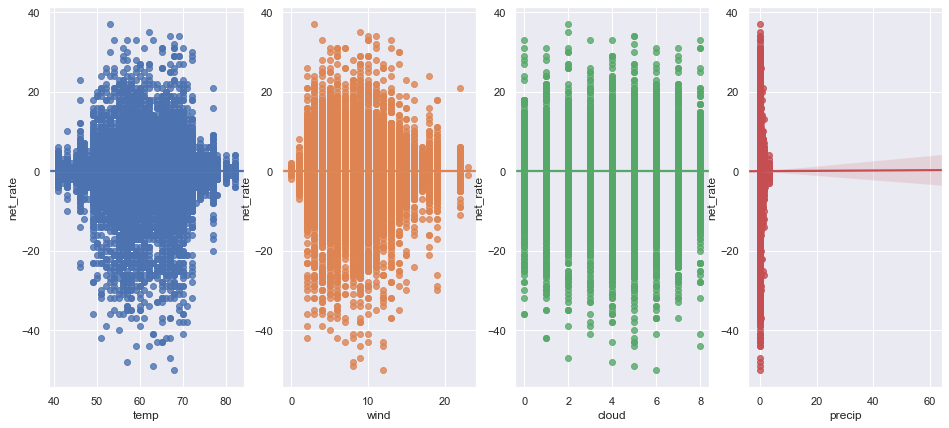

In [164]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
fig.set_size_inches(16, 7)
sns.regplot(x="temp", y="net_rate", data=new_trip_data,ax=ax1)
sns.regplot(x="wind", y="net_rate", data=new_trip_data,ax=ax2)
sns.regplot(x="cloud", y="net_rate", data=new_trip_data,ax=ax3)
sns.regplot(x="precip", y="net_rate", data=new_trip_data,ax=ax4)

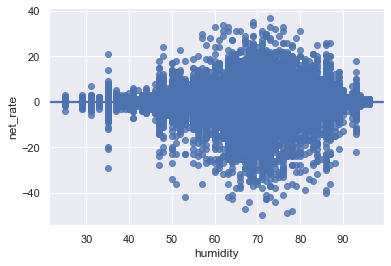

In [165]:
fig.set_size_inches(4, 7)
sns.regplot(x='humidity', y='net_rate', data=new_trip_data)

In [166]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# output = enc.fit_transform(np.asarray(list(new_trip_data['weekday'])).reshape(-1,1))
# new_trip_data['weekday'] = output

In [167]:
# enc1 = OneHotEncoder()
# output = enc1.fit_transform(np.asarray(list(new_trip_data['month'])).reshape(-1,1))
# new_trip_data['month'] = output

In [168]:
# new_trip_data['month'].loc[0]
# np.asarray(list(new_trip_data['weekday'])).reshape(-1,1)

In [30]:
new_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198156 entries, 0 to 198155
Data columns (total 14 columns):
start_count    198156 non-null float64
end_count      198156 non-null float64
date           198156 non-null object
time           198156 non-null object
station        198156 non-null float64
net_rate       198156 non-null float64
zip_code       198156 non-null int64
weekday        198156 non-null object
month          198156 non-null object
temp           198076 non-null float64
wind           198142 non-null float64
precip         198142 non-null float64
cloud          198142 non-null float64
humidity       197706 non-null float64
dtypes: float64(9), int64(1), object(4)
memory usage: 27.7+ MB


In [31]:
# imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# new_trip_data.drop(['date', 'weekday', 'month'], axis=1).loc[:,:] = imp_median.fit_transform(new_trip_data.drop(['date', 'weekday', 'month'], axis=1))
# new_trip_data['temp'] = new_trip_data['temp'].astype('float64')
# new_trip_data['wind'] = new_trip_data['wind'].astype('float64')
# new_trip_data['precip'] = new_trip_data['precip'].astype('float64')
# new_trip_data['cloud'] = new_trip_data['cloud'].astype('float64')
# new_trip_data['humidity'] = new_trip_data['humidity'].astype('float64')
new_trip_data = new_trip_data.fillna(new_trip_data.median())
new_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198156 entries, 0 to 198155
Data columns (total 14 columns):
start_count    198156 non-null float64
end_count      198156 non-null float64
date           198156 non-null object
time           198156 non-null object
station        198156 non-null float64
net_rate       198156 non-null float64
zip_code       198156 non-null int64
weekday        198156 non-null object
month          198156 non-null object
temp           198156 non-null float64
wind           198156 non-null float64
precip         198156 non-null float64
cloud          198156 non-null float64
humidity       198156 non-null float64
dtypes: float64(9), int64(1), object(4)
memory usage: 22.7+ MB


In [32]:
def convert_month_to_num(x):
    if x == 'January':
        return 1
    elif x == 'February':
        return 2
    elif x == 'March':
        return 3
    elif x == 'April':
        return 4
    elif x == 'May':
        return 5
    elif x == 'June':
        return 6
    elif x == 'July':
        return 7
    elif x == 'August':
        return 8
    elif x == 'September':
        return 9
    elif x == 'October':
        return 10
    elif x == 'November':
        return 11
    elif x == 'December':
        return 12

def convert_weekday_to_num(x):
    if x == 'Monday':
        return 'workday'
    elif x == 'Tuesday':
        return 'workday'
    elif x == 'Wednesday':
        return 'workday'
    elif x == 'Thursday':
        return 'workday'
    elif x == 'Friday':
        return 'workday'
    elif x == 'Saturday':
        return 'weekend'
    elif x == 'Sunday':
        return 'weekend'

# new_trip_data['weekday'] = new_trip_data['weekday'].apply(lambda x: convert_weekday_to_num(x))
# new_trip_data['month'] = new_trip_data['month'].apply(lambda x: convert_month_to_num(x)).astype(float)

categorical_features = ['weekday', 'month']
new_trip_data = pd.get_dummies(new_trip_data, columns=categorical_features)

In [33]:
new_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198156 entries, 0 to 198155
Data columns (total 31 columns):
start_count          198156 non-null float64
end_count            198156 non-null float64
date                 198156 non-null object
time                 198156 non-null object
station              198156 non-null float64
net_rate             198156 non-null float64
zip_code             198156 non-null int64
temp                 198156 non-null float64
wind                 198156 non-null float64
precip               198156 non-null float64
cloud                198156 non-null float64
humidity             198156 non-null float64
weekday_Friday       198156 non-null uint8
weekday_Monday       198156 non-null uint8
weekday_Saturday     198156 non-null uint8
weekday_Sunday       198156 non-null uint8
weekday_Thursday     198156 non-null uint8
weekday_Tuesday      198156 non-null uint8
weekday_Wednesday    198156 non-null uint8
month_April          198156 non-null uint8
month_Aug

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_trip_data.drop(['net_rate', 'date', 'start_count', 'end_count'], axis=1), new_trip_data['net_rate'])
print(X_train.shape, X_test.shape, y_train.shape)

(148617, 27) (49539, 27) (148617,)


In [35]:
## Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape)

(148617, 27) (49539, 27)


In [36]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math 
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
# yLabelsLog = np.log1p(yLabels)
lModel.fit(X = X_train,y = y_train)

# Make predictions
preds = lModel.predict(X= X_train)
print ("RMSE Value For Linear Regression: ",math.sqrt(metrics.mean_squared_error(y_train, preds)))

RMSE Value For Linear Regression:  2.9201612774977965


In [37]:
lModel.coef_

array([-7.09864915e-02,  8.66739203e-03,  5.46987733e-03,  3.92014657e-03,
        1.78994211e-03,  2.51398720e-03, -9.94196045e-04,  1.75709666e-03,
       -2.02536663e+11, -2.04998452e+11, -1.61532210e+11, -1.52964195e+11,
       -2.05157576e+11, -2.07347045e+11, -2.07175122e+11, -1.00961898e+11,
       -1.02385927e+11, -9.04733971e+10, -9.60918744e+10, -9.83879710e+10,
       -1.03457807e+11, -1.01777666e+11, -1.02523912e+11, -9.99752954e+10,
       -9.59249086e+10, -1.04055074e+11, -1.02094910e+11])

In [38]:
# Make predictions
preds = lModel.predict(X=X_test)
print ("RMSE Value For Linear Regression: ",math.sqrt(metrics.mean_squared_error(y_test, preds)))

RMSE Value For Linear Regression:  2.911014181456538


In [39]:
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5,
                                min_child_weight=1.5, n_estimators=1000, reg_alpha=0.01, reg_lambda=1e-05,
                                subsample=0.6, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
preds = xgb_model.predict(X_train)
print ("RMSE Value For Linear Regression: ",math.sqrt(metrics.mean_squared_error(y_train, preds)))

preds = xgb_model.predict(X_test)
print ("RMSE Value For Linear Regression: ",math.sqrt(metrics.mean_squared_error(y_test, preds)))

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:49:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE Value For Linear Regression:  2.1016262829838364
RMSE Value For Linear Regression:  2.1798148707125904


In [40]:
print(xgb_model.feature_importances_)
new_trip_data.drop(['net_rate', 'date', 'start_count', 'end_count'], axis=1).columns
# OrderedDict(sorted(xgb_model.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

[0.18313618 0.14892083 0.01252835 0.01423374 0.01536893 0.01352507
 0.01329273 0.01581728 0.01288817 0.0190172  0.15572403 0.12396202
 0.01651397 0.02398004 0.0153601  0.01710288 0.01603655 0.02291142
 0.01341806 0.01717121 0.01711456 0.01894551 0.01782641 0.01746972
 0.02003348 0.01693465 0.02076692]


Index(['time', 'station', 'zip_code', 'temp', 'wind', 'precip', 'cloud',
       'humidity', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September'],
      dtype='object')

In [38]:
#for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6],                         
   'min_child_weight':[1.5,6],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[100],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]  
}

xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=42)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X_train, y_train)
print (gsearch1.cv_results_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    9.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   36.8s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   46.6s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  2.7min
[Para

[01:11:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [39]:
print (gsearch1.cv_results_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

{'mean_fit_time': array([ 8.12201937,  7.46034861,  9.03954228,  8.41131798,  9.35143272,
        8.65817865,  9.7056977 ,  9.03957582,  9.60725339,  8.89885934,
        9.44340905,  8.66476599,  9.48484476,  8.75654205,  9.76073337,
        9.0464023 , 10.75305001,  9.98848446, 11.44473537, 10.73540998,
       10.33984907,  9.61850031,  9.83542323,  9.05764397,  9.39820925,
        8.55753318,  9.54254762,  8.85414505,  9.36114399,  8.65017732,
       10.30352259,  9.59963361,  9.85660648,  9.1177667 ,  9.76071803,
        9.06398535, 13.03369983, 11.86650809, 12.78349702, 11.69584004,
       16.61645738, 15.51743134, 15.32143092, 14.38908593, 14.61483105,
       13.37014834, 15.94290233, 14.74870769, 14.71664262, 13.48110723,
       13.0369246 , 11.79317093, 12.88160332, 11.71684504, 13.50578125,
       12.31149475, 13.61826388, 12.40606221, 13.14116565, 11.99377386,
       12.82038291, 11.70016972, 13.01506527, 11.89206497, 13.28899026,
       12.12144796, 13.33880552, 12.10468197, 